---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib notebook

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

## Degree Distribution 

Preferential Attachment Model generates a network with a Power Law like distribution. On a log-log scale, this distribution looks like a straight line so let's plot those graphs.

<IPython.core.display.Javascript object>


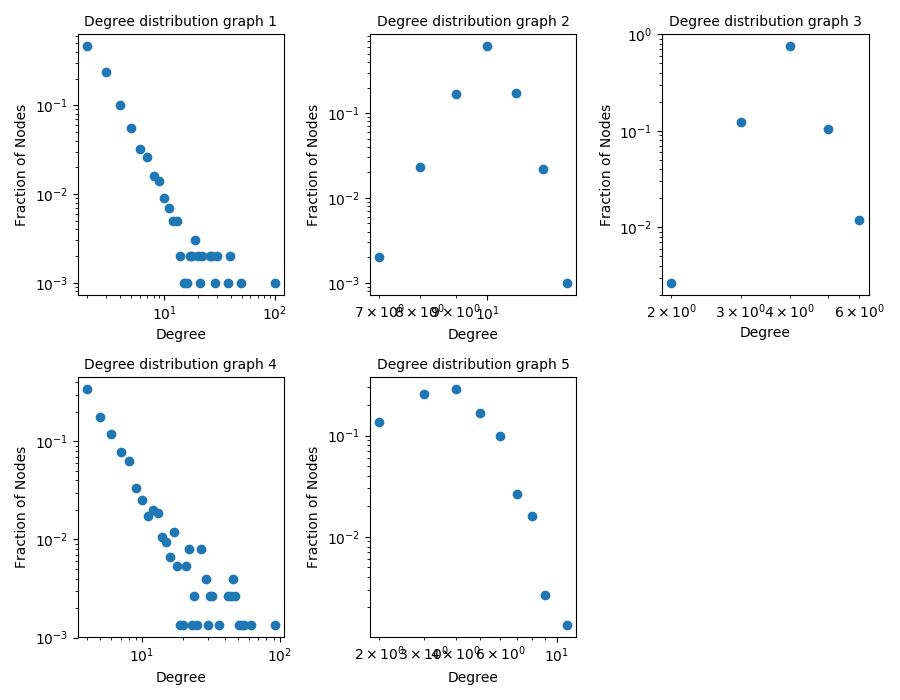

In [138]:
def first_graph_rep():    
    # Plotting the degree distributions
    fig = plt.figure(figsize=(9,7))

    for n in range(0, len(P1_Graphs)):
        graph = P1_Graphs[n]
        degrees = graph.degree()
        degree_values = sorted(set(degrees.values()))
        histo = [(list(degrees.values()).count(i))/float(nx.number_of_nodes(graph)) for i in degree_values]
        
        fig.add_subplot(2, 3, n+1)
        plt.plot(degree_values, histo, 'o')
        plt.xscale('log')
        plt.xlabel('Degree')
        plt.yscale('log')
        plt.ylabel('Fraction of Nodes')
        plt.title('Degree distribution graph {}'.format(n+1), fontsize=10)
    
    fig.tight_layout()

first_graph_rep()

- The first network seems to have been generated with a Preferential Attachment algorithm
- The second network does not seem to have been generated with a Preferential Attachment algorithm
- The third network does not seem to have been generated with a Preferential Attachment algorithm
- The fourth network seems to have been generated with a Preferential Attachment algorithm
- The fifth network does not seem to have been generated with a Preferential Attachment algorithm

## Average Clustering Coefficient - Average Shortest Path

To confirm what the plots are showing let's compute the average clustering coefficient and the average shortest path. Small World Models should have a high clustering coefficient and low shortest path

In [141]:
def clustering_shortest_path():
    for n in range(0, len(P1_Graphs)):
        print('Average clusering coefficient for network {} : '.format(n+1), nx.average_clustering(P1_Graphs[n]))
        print('Average shortest path for network {} : '.format(n+1), nx.average_shortest_path_length(P1_Graphs[n]), '\n')

clustering_shortest_path()


Average clusering coefficient for network 1 :  0.03167539146454044
Average shortest path for network 1 :  4.099161161161161 

Average clusering coefficient for network 2 :  0.5642419635919628
Average shortest path for network 2 :  5.089871871871872 

Average clusering coefficient for network 3 :  0.4018222222222227
Average shortest path for network 3 :  9.378702269692925 

Average clusering coefficient for network 4 :  0.03780379975223251
Average shortest path for network 4 :  3.1048046283934134 

Average clusering coefficient for network 5 :  0.0033037037037037037
Average shortest path for network 5 :  5.0785509568313305 



- For the first network we can confirm that it has been created with the Preferential Attachment algorithm (the average clustering is low)
- For the second network we can confirm that it has been created with the Small World algotithm. Average clustering is high and the average shortest path is low so we can suppose that the probability of rewiring is low.
- For the third network we can confirm that it has been created with the Small World algotithm. Average clustering is high and the average shortest path is low (relatively speaking compared to the number of nodes) so we can suppose that the probability of rewiring is low.
- For the fourth network we can confirm that it has been created with the Preferential Attachment algorithm (the average clustering is low)
- For the fifth network we can confirm that it has been created with the Small World algotithm. Average clustering is very low and the average shortest path is low so we can suppose that the probability of rewiring is very high.


In [143]:
def graph_identification():
    
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

graph_identification()

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

---

# Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [2]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


## Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [3]:
# Machine learning modules from Scikit-Learn
# Extremely important to create a training set and a test set from our data to prevent overfitting
from sklearn.model_selection import train_test_split
# Model weel suited for mixted feature types and quick with prediction
# Import DummyClassifier to test score for predicting the majority class
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
# Strings cannot be passed in the fit() method of our classifier, preprocessing is needed
from sklearn import preprocessing
# Use of other evaluation metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Normalization
from sklearn.preprocessing import MinMaxScaler

## I- Training data and Classifier (Part 2A) 

### Data Extraction & Manipulation

In [69]:
# Initialize the dataframe, using the nodes as the index
df = pd.DataFrame(index=G.nodes())

# Nodes attributes as columns
df['department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
df['management_salary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))

# Creating node based features
df['clustering'] = pd.Series(nx.clustering(G))
df['degree'] = pd.Series(G.degree())
df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df['closeness_centrality'] = pd.Series(nx.closeness_centrality(G))
df['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G, normalized=True, endpoints=False))
df['pagerank'] = pd.Series(nx.pagerank(G, alpha = 0.9))

# Reorganizing colums
df = df[['department', 'clustering', 'degree', 'degree_centrality',
         'closeness_centrality', 'betweenness_centrality', 'pagerank',
         'management_salary']]

# Identify missing ManagementSalary value and extract the data 
# This will be the new data to predict
to_predict_df = df.copy()
to_predict_df = to_predict_df[to_predict_df['management_salary'].isnull()]
to_predict_df.loc[:, 'management_salary'] = ''

# Delete rows where ManagementSalary is NaN in our original DataFrame
df.dropna(inplace=True)

# Creating our feature list and binary target labels 
X = df.loc[:, 'department':'pagerank']
y = df.iloc[:, -1]
y = y.astype(int)

### Set creation - Model Training and Evaluation

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0)

gbt = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 2, random_state= 0).fit(X_train, y_train)
gbt_score_training = gbt.score(X_train, y_train)
gbt_score_validation = gbt.score(X_test, y_test)

print("Gradient Boosted Decision Tree training score : {:.2f}".format(gbt_score_training))
print("Gradient Boosted Decision Tree validation score : {:.2f}".format(gbt_score_validation))

Gradient Boosted Decision Tree training score : 0.97
Gradient Boosted Decision Tree validation score : 0.90


Accuracy score seems okay but seems too good to be true, let's compare it with a DummyClassifier score

In [78]:
dummy_majority = DummyClassifier(strategy= 'most_frequent').fit(X_train, y_train)
dummy_score = dummy_majority.score(X_test, y_test)

print("Dummy score : {:.2f}".format(dummy_score))

Dummy score : 0.84


It seems our scores are not that good since there are very close to the dummy score. Let's use another evaluation metric like AUCROC

<IPython.core.display.Javascript object>


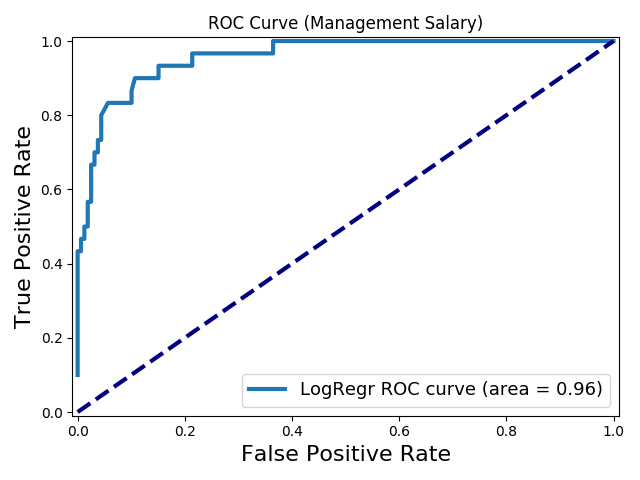

In [163]:
# Compute classifier score
gbt_scores = gbt.decision_function(X_test)

# ROC curve and Area Under the curve
false_positive_rate, true_positive_rate, thresholds_roc = roc_curve(y_test, gbt_scores)

auc_score = roc_auc_score(y_test, gbt_scores)
'''
plt.figure()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(false_positive_rate, true_positive_rate, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc_score))
plt.title('ROC Curve (Management Salary)')
plt.xlabel('False Positive Rate', size= 16)
plt.ylabel('True Positive Rate', size= 16)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=13)
plt.tight_layout()
'''

## II- Run the model and make predictions (Part 2A) 

### Data extraction and manipulation - Test file

In [84]:
X_predict = to_predict_df.loc[:, 'department':'pagerank']
y_predict = to_predict_df.iloc[:, -1].as_matrix()


### Passing our data to the Gradient Boosted Model

In [87]:
gbt_predictions = gbt.predict_proba(X_predict)[:, 1]

In [91]:
def salary_predictions():
    salary = pd.Series(gbt_predictions, index = to_predict_df.index)
    
    return salary

salary_predictions()

1       0.016678
2       0.973529
5       0.980542
8       0.229893
14      0.072499
18      0.031082
27      0.045708
30      0.811009
31      0.259259
34      0.022841
37      0.030751
40      0.026143
45      0.020390
54      0.290062
55      0.729389
60      0.149937
62      0.980542
65      0.980651
77      0.023711
79      0.022279
97      0.013825
101     0.002008
103     0.523286
108     0.038359
113     0.075567
122     0.000848
141     0.435758
142     0.980542
144     0.051251
145     0.600422
          ...   
913     0.013215
914     0.015080
915     0.000831
918     0.025693
923     0.017277
926     0.034375
931     0.008085
934     0.000854
939     0.000753
944     0.000854
945     0.017277
947     0.022765
950     0.064854
951     0.011614
953     0.001400
959     0.000753
962     0.000753
963     0.092633
968     0.040455
969     0.040455
974     0.025325
984     0.000854
987     0.068357
989     0.022765
991     0.061721
992     0.000753
994     0.000620
996     0.0008

## Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [5]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

## I- Training data and Classifier (Part 2B)

### Data Extraction & Manipulation

In [7]:
# Initialize the dataframe, using the nodes as the index
df2 = future_connections.copy()

# Link prediction problem measures as features / columns
df2['jaccard_coefficient'] = [i[2] for i in nx.jaccard_coefficient(G, future_connections.index)]
df2['ressource_allocation'] = [i[2] for i in nx.resource_allocation_index(G, future_connections.index)]
df2['adamic_adar'] = [i[2] for i in nx.adamic_adar_index(G, future_connections.index)]
df2['preferential_attachment'] = [i[2] for i in nx.preferential_attachment(G, future_connections.index)]
df2['common_neighbors'] = [len(list(nx.common_neighbors(G, x[0], x[1]))) for x in future_connections.index]

# Node Community assignment
for node in G.nodes():
    G.node[node]['community'] = G.node[node]['Department']
# Link prediction problem measures considering network structure, communities are departments
df2['community_cn'] = [i[2] for i in nx.cn_soundarajan_hopcroft(G, future_connections.index)]
df2['community_ra'] = [i[2] for i in nx.ra_index_soundarajan_hopcroft(G, future_connections.index)]

# Identify missing FutureConnections values and extract the data 
# This will be the new data to predict
to_predict_df2 = df2.copy()
to_predict_df2 = to_predict_df2[to_predict_df2['Future Connection'].isnull()]
to_predict_df2.loc[:, 'Future Connection'] = ''

# Delete rows where ManagementSalary is NaN in our original DataFrame
df2.dropna(inplace=True)

# Creating our feature list and binary target labels 
X2 = df2.loc[:, 'jaccard_coefficient':'community_ra']
y2 = df2.iloc[:, 0]
y2 = y2.astype(int)

### Set creation - Model Training and Evaluation

In [8]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, random_state= 0)

scaler = MinMaxScaler()
X_train_2_scaled = scaler.fit_transform(X_train_2)
X_test_2_scaled = scaler.transform(X_test_2)

rdf = RandomForestClassifier(n_estimators=100, max_depth=10).fit(X_train_2_scaled, y_train_2)
rdf_score_training = rdf.score(X_train_2_scaled, y_train_2)
rdf_score_validation = rdf.score(X_test_2_scaled, y_test_2)

print("Gradient Boosted Decision Tree training score : {:.2f}".format(rdf_score_training))
print("Gradient Boosted Decision Tree validation score : {:.2f}".format(rdf_score_validation))

Gradient Boosted Decision Tree training score : 0.97
Gradient Boosted Decision Tree validation score : 0.96


Accuracy score seems okay but seems too good to be true, let's compare it with a DummyClassifier score

In [9]:
dummy_majority_2 = DummyClassifier(strategy= 'most_frequent').fit(X_train_2_scaled, y_train_2)
dummy_score_2 = dummy_majority_2.score(X_test_2_scaled, y_test_2)

print("Dummy score : {:.2f}".format(dummy_score_2))

Dummy score : 0.92


It seems our scores are not that good since there are very close to the dummy score. Let's use another evaluation metric like AUCROC

<IPython.core.display.Javascript object>


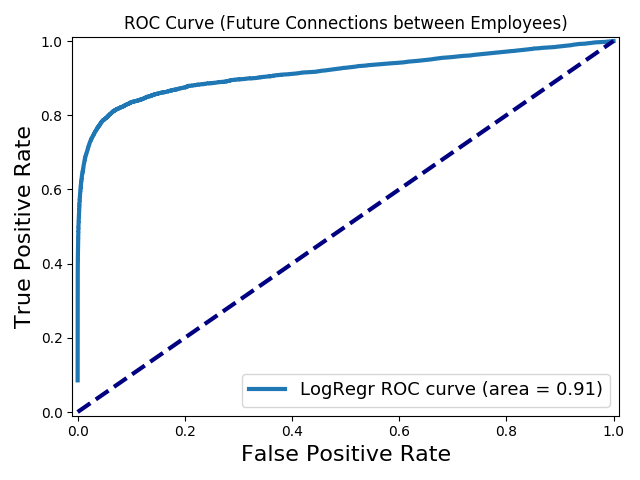

In [11]:
# Compute classifier score
rdf_scores = rdf.predict_proba(X_test_2_scaled)

# ROC curve and Area Under the curve
false_positive_rate_2, true_positive_rate_2, thresholds_roc_2 = roc_curve(y_test_2, rdf_scores[:,1])

auc_score_2 = roc_auc_score(y_test_2, rdf_scores[:,1])
'''
plt.figure()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(false_positive_rate_2, true_positive_rate_2, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc_score_2))
plt.title('ROC Curve (Future Connections between Employees)')
plt.xlabel('False Positive Rate', size= 16)
plt.ylabel('True Positive Rate', size= 16)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=13)
plt.tight_layout()
'''

## II- Run the model and make predictions (Part 2B)

### Data extraction and manipulation - Test file

In [12]:
X_predict_2 = to_predict_df2.loc[:, 'jaccard_coefficient':'community_ra']
X_predict_2_scaled = scaler.transform(X_predict_2)
y_predict_2 = to_predict_df2.iloc[:, 0].as_matrix()

### Passing our data to the Random Forest Model

In [13]:
rdf_predictions = rdf.predict_proba(X_predict_2_scaled)[:, 1]

In [14]:
def new_connections_predictions():
    
    connections = pd.Series(rdf_predictions, index = to_predict_df2.index)
    
    return connections
        
new_connections_predictions()

(107, 348)    0.024755
(542, 751)    0.012576
(20, 426)     0.540990
(50, 989)     0.012664
(942, 986)    0.013580
(324, 857)    0.012664
(13, 710)     0.106025
(19, 271)     0.144812
(319, 878)    0.012458
(659, 707)    0.012709
(49, 843)     0.012424
(208, 893)    0.012579
(377, 469)    0.011346
(405, 999)    0.016660
(129, 740)    0.010574
(292, 618)    0.019319
(239, 689)    0.012357
(359, 373)    0.016300
(53, 523)     0.432106
(276, 984)    0.012179
(202, 997)    0.012267
(604, 619)    0.036270
(270, 911)    0.012369
(261, 481)    0.059307
(200, 450)    0.993437
(213, 634)    0.012539
(644, 735)    0.035287
(346, 553)    0.012656
(521, 738)    0.012223
(422, 953)    0.014747
                ...   
(672, 848)    0.012369
(28, 127)     0.993040
(202, 661)    0.012775
(54, 195)     1.000000
(295, 864)    0.012781
(814, 936)    0.012561
(839, 874)    0.013580
(139, 843)    0.012684
(461, 544)    0.013102
(68, 487)     0.012661
(622, 932)    0.012609
(504, 936)    0.017406
(479, 528) 